# Project Proposal — Heart Disease Prediction

## 1 - Introduction

Heart disease and its effective diagnosis is a global health challenge. In this proposal, we aim to address diagnosing heart diseases using machine learning techniques. We will attempt to detect the presence of heart disease in patients by leveraging a heart disease dataset obtained from Kaggle. 
###         Data Selection and Justification

While the original dataset from Kaggle comprises 16 variables, we have strategically chosen 6 variables based on their clinically established correlation with heart disease. By focusing on a subset of six variables, we aim to create a model that is both efficient and effective, avoiding the complexity and potential overfitting associated with using a larger number of variables.

1. **Patient ID (id)**: This identifier is used to track individual patient data.
2. **Age (age)**: Age is a well-known risk factor for heart disease. Older individuals have a higher risk, making this variable crucial for our model.
3. **Resting Blood Pressure (trestbps)**: High blood pressure is a known risk factor for heart disease. It can lead to hardening and thickening of the arteries, increasing heart disease risk.
4. **Serum Cholesterol (chol)**: High cholesterol levels can lead to atherosclerosis, increasing heart disease risk.
5. **Maximum Heart Rate (thalach)**: Lower maximum heart rate during exercise is associated with a higher risk of heart disease.
6. **Heart Disease (presence)**: This variable, indicating the degree of blockages in major vessels, is a direct measure of heart disease. In the initial dataset, the diagnosis (num) ranges from 0 (no presence) to 4. However, we have compressed it into two categories:

     - P (present): < 50% diameter narrowing, indicating significant heart disease.
     - A (absent): > 50% diameter narrowing, indicating no significant heart disease.
     
The decision to compress the "num" column (or presence in our study) into two classes (P and A) stems from the need for a clear, binary classification for our KNN classification model. This simplification also addresses potential issues with ambiguous labels in the dataset—allowing us to effectively train our model to distinguish only between two crucial states of heart diseases (present or absent). 

###                Project Goal

#### Can a K-nearest neighbors (KNN) classification effectively diagnose heart disease using age, Resting Blood Pressure, maximum heart rate, blood pressure, and cholesterol levels as predictors?
This approach aims to provide a simplified yet accurate tool for early heart disease diagnosis, potentially aiding in prompt treatment and management.



## 2 - Preliminary exploratory data analysis

 ### 2.a. Data Cleaninng and Wrangling

In [1]:
library(tidyverse)
library(repr)
library(dplyr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.4     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

### Preparing the Heart Disease Dataframe

In [2]:
## Read the data
## We are using the heart disease data. As suggested by the professor we downloaded the csv file from kaggle and uploaded it into our notebook

url <- "https://raw.githubusercontent.com/MAmouzouvi/dsci-100-2022w1-group-10/main/data/heart_disease_uci.csv"

heart_disease_uci <- read_csv(url)
head(heart_disease_uci)

Rows: 920 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): sex, dataset, cp, restecg, slope, thal
dbl (8): id, age, trestbps, chol, thalch, oldpeak, ca, num
lgl (2): fbs, exang

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<lgl>,<chr>,<dbl>,<lgl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
1,63,Male,Cleveland,typical angina,145,233,TRUE,lv hypertrophy,150,FALSE,2.3,downsloping,0,fixed defect,0
2,67,Male,Cleveland,asymptomatic,160,286,FALSE,lv hypertrophy,108,TRUE,1.5,flat,3,normal,2
3,67,Male,Cleveland,asymptomatic,120,229,FALSE,lv hypertrophy,129,TRUE,2.6,flat,2,reversable defect,1
4,37,Male,Cleveland,non-anginal,130,250,FALSE,normal,187,FALSE,3.5,downsloping,0,normal,0
5,41,Female,Cleveland,atypical angina,130,204,FALSE,lv hypertrophy,172,FALSE,1.4,upsloping,0,normal,0
6,56,Male,Cleveland,atypical angina,120,236,FALSE,normal,178,FALSE,0.8,upsloping,0,normal,0


### Selection  
Now we reduced the data set by including only the variables selected. 

The variable `num` is the diagnosis of the heart disease so let's change it `presence` which is a more descriptive name.

In [3]:
heart_disease_data <- heart_disease_uci |> 
         rename(presence = num) |>
         select(id, age, trestbps, chol, thalch, presence)
heart_disease_data

id,age,trestbps,chol,thalch,presence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,63,145,233,150,0
2,67,160,286,108,2
3,67,120,229,129,1
⋮,⋮,⋮,⋮,⋮,⋮
918,55,122,223,100,2
919,58,NA,385,NA,0
920,62,120,254,93,1


### Categorical Variable and Data Wrangling

Since we will be working with `presence` as a categorical variable, let's convert it to a factor type. 

Let's also compress the `presence` variable into two classes (`P` for present and `A` for absent) just allow a clear binary classification for our KNN classification model. This is to address potential issues with ambiguous labels in the dataset—allowing us to effectively train our model to distinguish only between two crucial states of heart diseases (present or absent).

Finally, we remove rows with `NA` values

In [4]:
# mutate presence to a factor
heart_disease_data <- heart_disease_data |>
            mutate(presence = as_factor(presence)) |>
            mutate(presence = ifelse(presence == 0, "P", "A"))

# Taking out the NA value in the dataset
heart_disease_data <- na.omit(heart_disease_data)
heart_disease_data

id,age,trestbps,chol,thalch,presence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,63,145,233,150,P
2,67,160,286,108,A
3,67,120,229,129,A
⋮,⋮,⋮,⋮,⋮,⋮
916,54,127,333,154,A
918,55,122,223,100,A
920,62,120,254,93,A


### Splitting the Data into Training and Testing Sets

In [10]:
set.seed(3456)

# Split the heart disease data into training and testing sets 
heart_disease_split <- initial_split(heart_disease_data, prop = 0.75, strata = presence)  
heart_disease_train <- training(heart_disease_split)   
heart_disease_test <- testing(heart_disease_split)

 ### 2.b. Summary Tables 

#### -> Percentage of observations in presence (N vs P)

In [14]:
set.seed(3456)

# Table that reports the total number of observations in the training data (missing values removed)
num_of_observations <- nrow(heart_disease_train)

# Table that reports the percentage of observations in presence (N vs P)
percentage_per_P_and_A <- heart_disease_train |>
  group_by(presence) |>
  summarize(
    count = n(),
    percentage = n() / num_of_observations * 100
  )
percentage_per_P_and_A

presence,count,percentage
<chr>,<int>,<dbl>
A,345,55.28846
P,279,44.71154


#### -> Predictor Variable Mean 

In [15]:
set.seed(3456)
# table that reports the means of the predictor variable
# mean_of_predictors_tbl <- heart_disease_train |>
#   summarize(across(age:thalch, ~ mean(.))) |>
#   pivot_longer(cols = everything(), names_to = "Variable", values_to = "Mean")

mean_of_predictors <- heart_disease_train |>
  group_by(presence) |>
  summarize(across(age:thalch, ~ mean(.)))

mean_of_predictors

presence,age,trestbps,chol,thalch
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
A,55.53333,134.4290,172.3507,128.1130
P,50.31183,129.0072,227.8889,150.1147


## 3 - Visualization

## 3.a. Scaling the Dataframe (THIS IS WHERE WE START IMPLEMENTING THE NEW VISUALIZATIONS )

In [16]:
set.seed(3456)
# center and sacle the data
heart_disease_recipe  <- recipe(presence ~ age + trestbps + chol + thalch, data = heart_disease_train) |>
                       step_scale(all_predictors()) |>
                       step_center(all_predictors()) |>
                       prep()

## scale training data
heart_disease_train_scaled <- bake(heart_disease_recipe, heart_disease_train)

heart_disease_train_scaled 

age,trestbps,chol,thalch,presence
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1.4838148,-0.6205049,0.2808761,-0.3474694,A
0.9462507,0.4132558,0.6251594,0.8560128,A
1.0537635,-0.1036246,0.5015705,0.3513267,A
⋮,⋮,⋮,⋮,⋮
0.4086866,-0.1036246,0.0866650,-1.6285956,P
1.5913277,0.1031276,0.5015705,0.5066147,P
-0.2363904,-0.9306331,0.5368816,-1.6285956,P


## Plots

In [2]:
install.packages("GGally")
library(GGally)

also installing the dependencies ‘labelled’, ‘broom.helpers’, ‘ggplot2’, ‘ggstats’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Loading required package: ggplot2

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


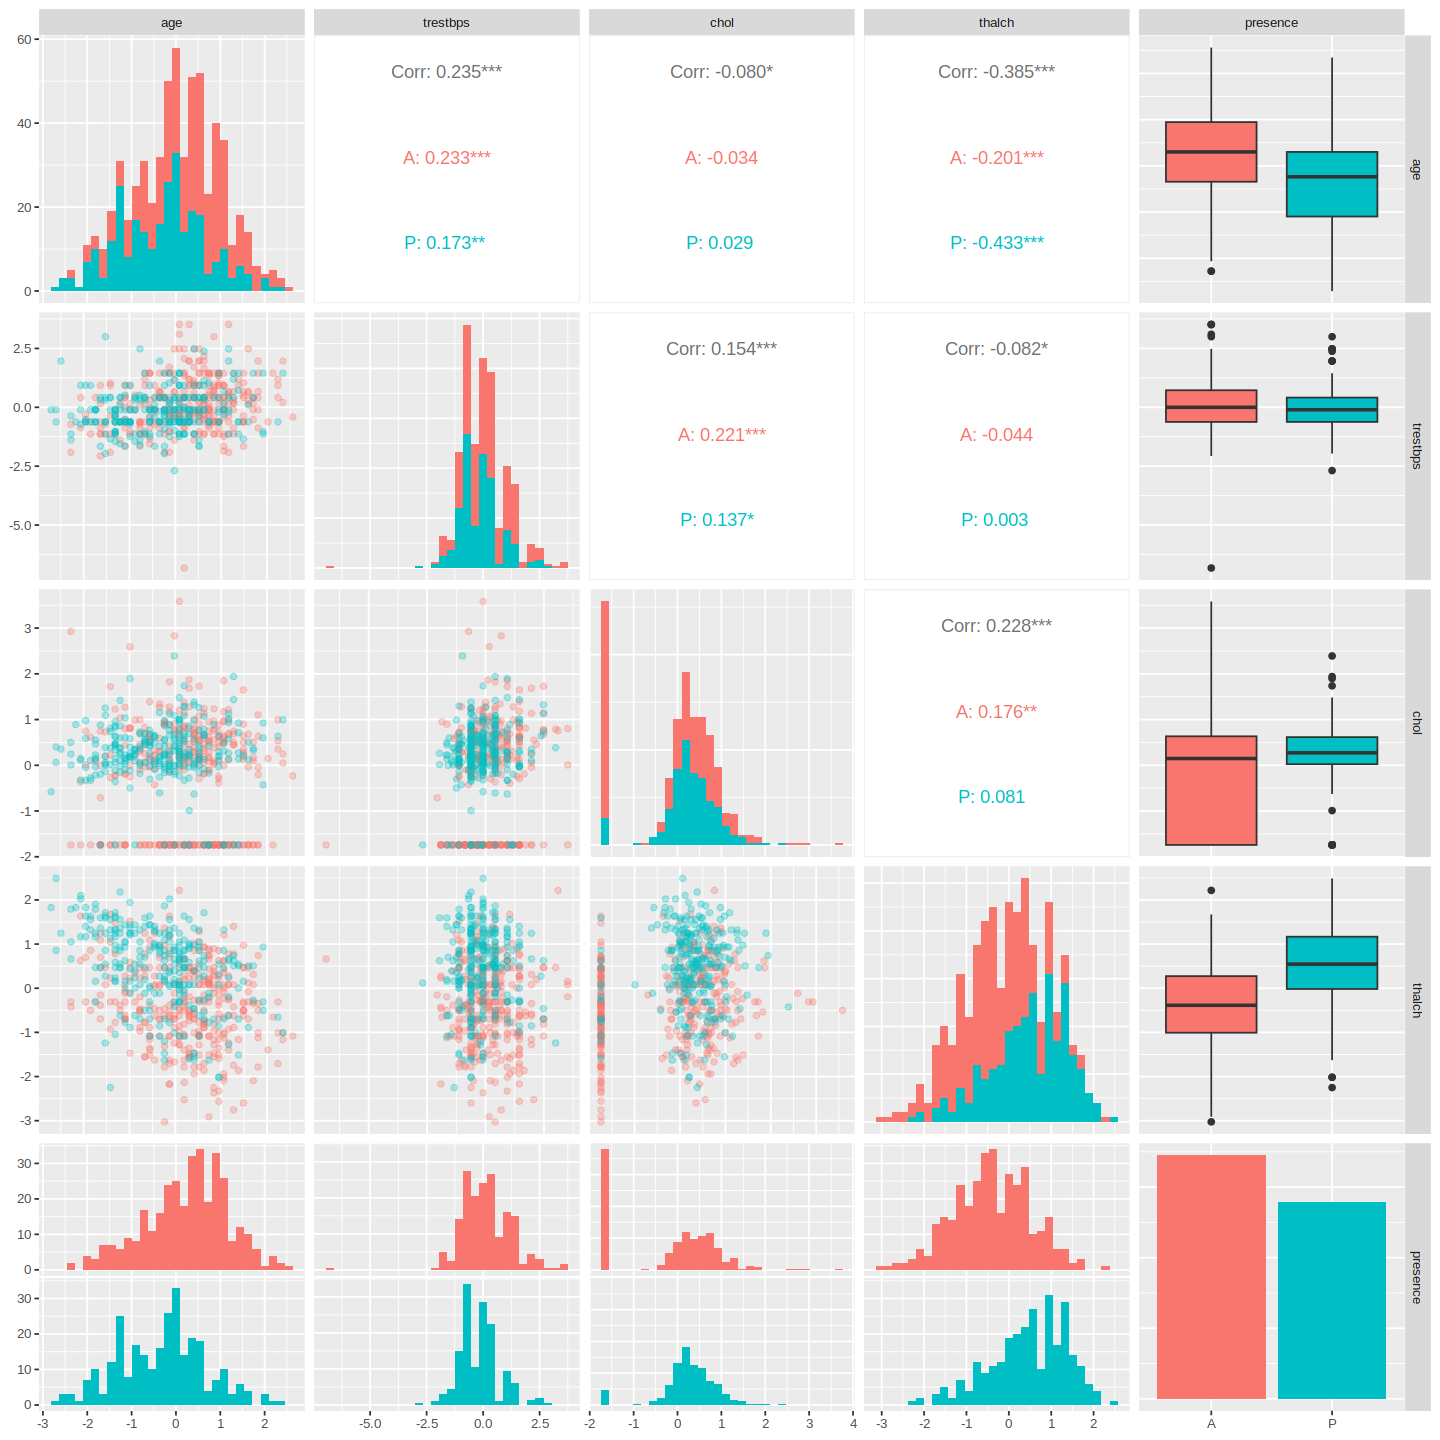

In [22]:
set.seed(3456)
# Getting the GGpair Plot to compare the trend between each variable 
options(repr.plot.width = 12, repr.plot.height = 12)
credit_pairplot <- heart_disease_train_scaled |> 
    ggpairs(
        mapping = aes(color = presence),
        lower = list(continuous = wrap('points', alpha = 0.3)),
        diag = list(continuous = "barDiag")
    ) +
    theme(text = element_text(size = 10))

credit_pairplot

### GGpair Graph Observation

Based on the above GGpair graph, we focused on the rightmost column to determine which predictors are more relevant for study. Our original predictors are "age", "trestbps", "chol", and "thalch". From the percentile graphs, we see that the "trestbps" (Resting Blood Pressure) percentile  boxes are in similar range, which indicates that the variable does not contribute to help differentiate between A(absent) and P(present) for the heart disease diagnosis. Therefore, we will eliminate the "trestbps" predictor to get better prediction results to our study. 


### 3.b. Data and Recipe updates / remove 'trestbps' variable 

In [17]:
set.seed(3456)
# adjusting the predictors

new_heart_disease_recipe  <- recipe(presence ~ age + chol + thalch, data = heart_disease_train) |>
                       step_scale(all_predictors()) |>
                       step_center(all_predictors()) |>
                       prep()

## scale training data
new_heart_disease_train_scaled <- bake(new_heart_disease_recipe, heart_disease_train)

new_heart_disease_train_scaled

age,chol,thalch,presence
<dbl>,<dbl>,<dbl>,<fct>
1.4838148,0.2808761,-0.3474694,A
0.9462507,0.6251594,0.8560128,A
1.0537635,0.5015705,0.3513267,A
⋮,⋮,⋮,⋮
0.4086866,0.0866650,-1.6285956,P
1.5913277,0.5015705,0.5066147,P
-0.2363904,0.5368816,-1.6285956,P


## 4. Data Searching /Modeling


In [27]:
install.packages("kknn")
library(kknn)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



k-values graph

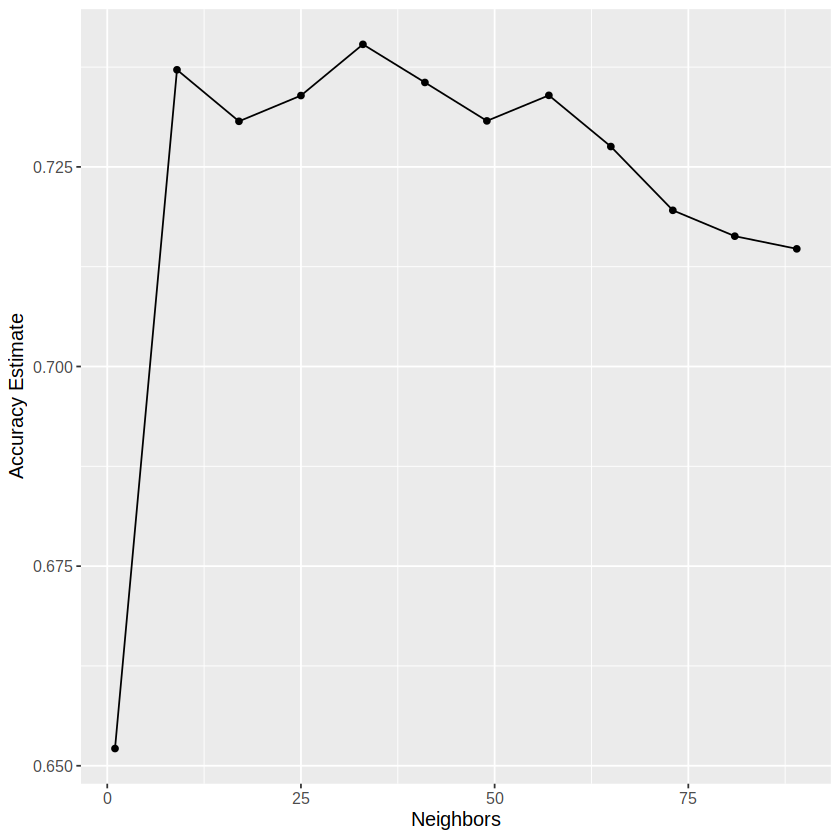

In [26]:
set.seed(3456)
# Test the testing sets with the workflow we have. 

# Create the spec for heart disease following the classification method
heart_disease_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification") 

k_vfold <- vfold_cv(new_heart_disease_train_scaled, v = 5, strata = presence)




k_vals <- tibble(neighbors = seq(from = 1, to = 90, by = 8))

knn_fit <- workflow() |>
    add_recipe(new_heart_disease_recipe) |>
    add_model(heart_disease_spec) |>
    tune_grid(resamples = k_vfold, grid = k_vals) |>
    collect_metrics() 




accuracies <- knn_fit |>
    filter(.metric == "accuracy")

cross_val_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 12))

# This code print out the graph for showing K-nearest Neighbor Mean Distribution
cross_val_plot

finding the K-value (highest point on the graph

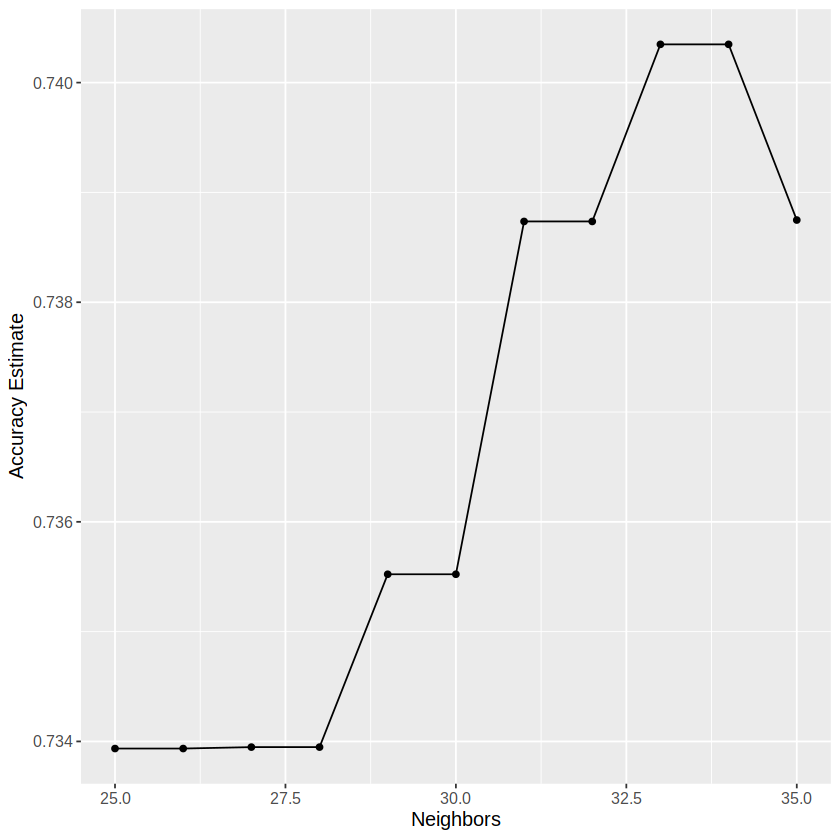

In [27]:
set.seed(3456)
k_vals <- tibble(neighbors = seq(from = 25, to = 35, by = 1))

knn_fit <- workflow() |>
    add_recipe(new_heart_disease_recipe) |>
    add_model(heart_disease_spec) |>
    tune_grid(resamples = k_vfold, grid = k_vals) |>
    collect_metrics() 

accuracies <- knn_fit |>
    filter(.metric == "accuracy")

cross_val_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 12))

# This code print out the graph for showing K-nearest Neighbor Mean Distribution
cross_val_plot

### K values = 33.

In [34]:
set.seed(3456)

heart_disease_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 33) |>
    set_engine("kknn") |>
    set_mode("classification") 


heart_disease_fit_k33 <- workflow() |>
    add_recipe(new_heart_disease_recipe) |>
    add_model(heart_disease_spec) |>
    fit(data = new_heart_disease_train_scaled)

knn_fit

# # # For K-nearest Neighbour, we will be using 33 based on our tuning

# heart_disease_spec_k33 <- nearest_neighbor(weight_func = "rectangular", neighbors = 33) |>
#     set_engine("kknn") |>
#     set_mode("classification") 

# # Create fit model with heart_disease_train dataset
# heart_disease_fit_k28 <- workflow() |>
#       add_recipe(new_heart_disease_recipe) |>
#       add_model(heart_disease_spec_k33) |>
#       fit(data = new_heart_disease_train_scaled)

# # heart_disease_fit 
heart_dis_test_predictions <- predict(heart_disease_fit_k33, heart_disease_test) |>
      bind_cols(heart_disease_test)

heart_dis_test_predictions

# accurary <- heart_dis_test_predictions |> metrics(truth = presence, estimate = .pred_class)

# tail(accurary)



══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(33,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2532051
Best kernel: rectangular
Best k: 33

.pred_class,id,age,trestbps,chol,thalch,presence
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
P,2,67,160,286,108,A
P,10,53,140,203,155,A
P,13,56,130,256,142,A
⋮,⋮,⋮,⋮,⋮,⋮,⋮
P,898,64,130,258,130,A
P,918,55,122,223,100,A
A,920,62,120,254,93,A


In [ ]:

# # Now we find the minimum RMSPE along with it's associated metrics such as mean and standard error
# # This helps us find the number of neighbors that will serve as the best k value to use. 

# heart_dis_min <- heart_dis_results |>
#    filter(.metric == "rmse") |>
#    slice_min(mean, n = 1)

# heart_dis_min

# k_min <- heart_dis_min |>
#          pull(neighbors)

# heart_dis_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
#          set_engine("kknn") |>
#          set_mode("regression")

# heart_dis_best_fit <- workflow() |>
#          add_recipe(heart_disease_train_recipe) |>
#          add_model(heart_disease_best_spec) |>
#          fit(data = heart_disease_training)
# # The above data used could be wrong, could be heart_disease_training_scaled

# heart_dis_summary <- heart_dis_best_fit |>
#           predict(heart_disease_test) |>
#           bind_cols(heart_disease_test) |>
#           metrics(truth = presence, estimate = .pred)

# heart_dis_summary

## 3 - Method


First, we will import the dataset and perform data processing. This includes handling any missing values, addressing outliers, and standardizing our selected numerical predictors : age (age), maximum heart rate achieved (thalch), resting blood pressure (trestbps),and serum cholesterol (chol). 

Next, we will split the data into training and testing sets to develop and train  our classification model. We will use the K-nearest neighbors algorithm, setting an appropriate value for 'K' through cross-validation.

After standardizing our predictors we will create multiple scatterplots or colour code bar-charts  for the presence (P) or absence (N) of heart disease. Through visualization, we aim to discern any patterns or correlations between the variables (such as Age and Serum Cholesterol), which will aid in understanding their individual impacts on heart disease diagnosis.

Subsequently, we will proceed to fit the K-nearest neighbors model to the training data. Using the testing data, we will assess the model's performance. These tools will enable us to comprehensively evaluate the classifier's efficacy in accurately predicting the presence of heart disease.


## 4 - Expected Outcomes and Significance

Our group expect to find whether K-nearest neighbors classification is an effective method for diagnosing heart disease based on our predictors. We also expect to evaluate the model's performance in terms of accuracy, sensitivity, and recall ratios.

The Impacts of the Project Findings:
If KNN proves to be effective, it could contribute to a quicker and more effective diagnosis of heart disease and help professionals make more informed treatment options. This can significantly reduce healthcare expenses—decreasing unnecessary procedures. 

Future Questions:
- Are our proposals considered variables the most informative for heart disease diagnosis, or are there other key features that should be considered?
- How does knn performance compare to other machine learning algorithms or traditional diagnostic methods in diagnosing heart disease?


